<a href="https://colab.research.google.com/github/Trapti04/Machine_Learning_Colab_Workbooks/blob/master/04_feedforward_nn_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Neural Networks on a GPU with PyTorch



 * Creating a deep neural network with hidden layers
 * Using a non-linear activation function
 * Using a GPU (when available) to speed up training
 * Experimenting with hyperparameters to improve the model

### Using a GPU for faster training

You can use a [Graphics Processing Unit](https://en.wikipedia.org/wiki/Graphics_processing_unit) (GPU) to train your models faster if your execution platform is connected to a GPU manufactured by NVIDIA. Follow these instructions to use a GPU on the platform of your choice:

* _Google Colab_: Use the menu option "Runtime > Change Runtime Type" and select "GPU" from the "Hardware Accelerator" dropdown.
* _Kaggle_: In the "Settings" section of the sidebar, select "GPU" from the "Accelerator" dropdown. Use the button on the top-right to open the sidebar.
* _Binder_: Notebooks running on Binder cannot use a GPU, as the machines powering Binder aren't connected to any GPUs.
* _Linux_: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the [NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html).
* _Windows_: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the [NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html).
* _macOS_: macOS is not compatible with NVIDIA GPUs


If you do not have access to a GPU or aren't sure what it is, don't worry, you can execute all the code in this tutorial just fine without a GPU.

In [66]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib torch torchvision torchaudio

Finding some details on the colab compute

In [67]:
!df -h # disk information

Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   39G   40G  49% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G  4.0K  5.7G   1% /dev/shm
/dev/root       2.0G  1.2G  812M  59% /sbin/docker-init
/dev/sda1        86G   43G   44G  50% /opt/bin/.nvidia
tmpfs           6.4G   40K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [68]:
!cat /proc/meminfo # memory

MemTotal:       13298580 kB
MemFree:         4596184 kB
MemAvailable:    9903096 kB
Buffers:          115296 kB
Cached:          4184420 kB
SwapCached:            0 kB
Active:          3313428 kB
Inactive:        5008316 kB
Active(anon):    2800888 kB
Inactive(anon):    23004 kB
Active(file):     512540 kB
Inactive(file):  4985312 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               424 kB
Writeback:             0 kB
AnonPages:       4022092 kB
Mapped:           995156 kB
Shmem:             23744 kB
KReclaimable:     101020 kB
Slab:             164116 kB
SReclaimable:     101020 kB
SUnreclaim:        63096 kB
KernelStack:        5168 kB
PageTables:        24716 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6649288 kB
Committed_AS:    6312332 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       51212 kB
VmallocChunk:          0 kB
Percpu:          

In [141]:
!nvidia-smi -L # GPU info

GPU 0: Tesla T4 (UUID: GPU-c7a3380b-406e-7749-5dba-44fb29c551c8)


In [69]:
!cat /proc/cpuinfo # CPU info

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [70]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

We can download the data and create a PyTorch dataset using the `MNIST` class from `torchvision.datasets`. 

In [71]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Let's look at a couple of images from the dataset. The images are converted to PyTorch tensors with the shape `1x28x28` (the dimensions represent color channels, width and height). We can use `plt.imshow` to display the images. However, `plt.imshow` expects channels to be last dimension in an image tensor, so we use the `permute` method to reorder the dimensions of the image.

image.shape: torch.Size([1, 28, 28])
Label: 5


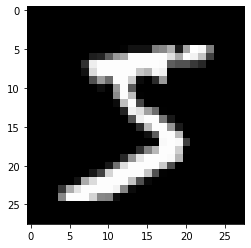

In [72]:
image, label = dataset[0]
print('image.shape:', image.shape)
#plt.imshow(image.permute(1, 2, 0), cmap='gray')
plt.imshow(np.squeeze(image.permute(1, 2, 0)),cmap='gray')
print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 1


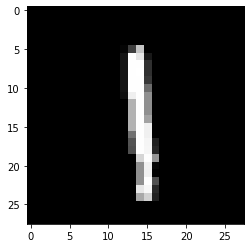

In [73]:
image, label = dataset[8]
print('image.shape:', image.shape)
plt.imshow(np.squeeze(image.permute(1, 2, 0)), cmap='gray')
print('Label:', label)

Next, let's use the `random_split` helper function to set aside 10000 images for our validation set.

In [74]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [75]:
batch_size=128

In [76]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

Can you figure out the purpose of the arguments `num_workers` and `pin_memory`? Try looking into the documentation: https://pytorch.org/docs/stable/data.html .

Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `matplotlib`.

images.shape: torch.Size([128, 1, 28, 28])


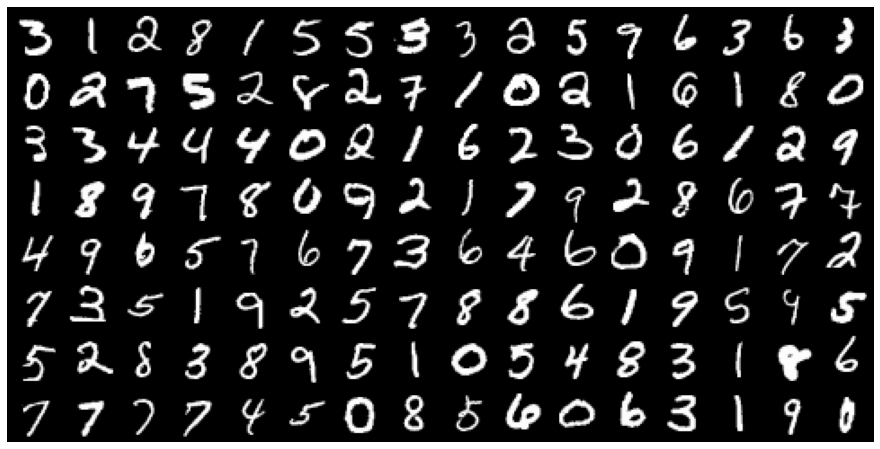

In [77]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a _hidden layer_ and an _output layer_. Additionally, we'll use an _activation function_ between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.

First, let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object.

In [78]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Next, let's create a `nn.Linear` object, which will serve as our _hidden_ layer. We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the _learning capacity_ of the model.

In [79]:
input_size = inputs.shape[-1]
hidden_size = 64 #32

In [80]:
layer1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing `inputs` through `layer1`.

In [81]:
inputs.shape

torch.Size([128, 784])

In [82]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 64])


The image vectors of size `784` are transformed into intermediate output vectors of length `32` by performing a matrix multiplication of `inputs` matrix with the transposed weights matrix of `layer1` and adding the bias. We can verify this using `torch.allclose`. For a more detailed explanation, review the tutorial on [linear regression](https://jovian.ai/aakashns/02-linear-regression).

In [83]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 64])

In [84]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e., each element of `layer_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture linear relationships between `inputs` and `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">


Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [85]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's apply the activation function to `layer1_outputs` and verify that negative values were replaced with 0.

In [86]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.8348662257194519
min(relu_outputs): 0.0


Now that we've applied a non-linear activation function, `relu_outputs` and `inputs` do not have a linear relationship. We refer to `ReLU` as the _activation function_, because for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

Next, let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

In [87]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [88]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [89]:
inputs.shape

torch.Size([128, 784])

As expected, `layer2_outputs` contains a batch of vectors of size 10. We can now use this output to compute the loss using `F.cross_entropy` and adjust the weights of `layer1` and `layer2` using gradient descent.

In [90]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3121, grad_fn=<NllLossBackward0>)

Thus, our model transforms `inputs` into `layer2_outputs` by applying a linear transformation (using `layer1`), followed by a non-linear activation (using `F.relu`), followed by another linear transformation (using `layer2`). Let's verify this by re-computing the output using basic matrix operations.

In [91]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [92]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

Note that `outputs` and `inputs` do not have a linear relationship due to the non-linear activation function `F.relu`. As we train the model and adjust the weights of `layer1` and `layer2`, we can now capture non-linear relationships between the images and their labels. In other words, introducing non-linearity makes the model more powerful and versatile. Also, since `hidden_size` does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can also introduce new hidden layers and apply the same non-linear activation after each hidden layer.

The model we just created is called a neural network. A _deep neural network_ is simply a neural network with one or more hidden layers. In fact, the [Universal Approximation Theorem](http://neuralnetworksanddeeplearning.com/chap4.html) states that a sufficiently large & deep neural network can compute any arbitrary function i.e. it can _learn_ rich and complex non-linear relationships between inputs and targets. Here are some examples:

* Identifying if an image contains a cat or a dog (or [something else](https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/))
* Identifying the genre of a song using a 10-second sample
* Classifying movie reviews as positive or negative based on their content
* Navigating self-driving cars using a video feed of the road
* Translating sentences from English to French (and hundreds of other languages)
* Converting a speech recording to text and vice versa
* And many more...

It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices, applying non-linear activations, and adjusting weights repeatedly using gradient descent can yield such astounding results. Deep learning models often contain millions of parameters, which can together capture far more complex relationships than the human brain can comprehend.

If we hadn't included a non-linear activation between the two linear layers, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.

In [93]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [94]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [95]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [96]:
torch.allclose(outputs2, outputs3, 1e-3)

True

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.


As discussed above, our model will contain one hidden layer. Here's what it looks like visually:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


Let's define the model by extending the `nn.Module` class from PyTorch.

In [97]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size_1, hidden_size_2, out_size):
        super().__init__()
        # hidden layer 1
        self.linear1 = nn.Linear(in_size, hidden_size_1)
        # hidden layer 2
        self.linear3 = nn.Linear(hidden_size_1, hidden_size_2)
        # output layer
        self.linear2 = nn.Linear(hidden_size_2, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        #Get intermediate outputs froom next hidden layer
        out = self.linear3(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We also need to define an `accuracy` function which calculates the accuracy of the model's prediction on an batch of inputs. It's used in `validation_step` above.

In [98]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We'll create a model that contains a hidden layer with 32 activations.

In [99]:
input_size = 784
hidden_size_1 = 64 # you can change this changed from 32
hidden_size_2 =32
num_classes = 10

In [100]:
model = MnistModel(input_size, hidden_size_1,hidden_size_2, out_size=num_classes)

Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

In [102]:
for t in model.parameters():
    print(t.shape)

torch.Size([64, 784])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset and pass them into our model.

In [103]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.315230131149292
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0810,  0.0993,  0.0617, -0.0099,  0.1752,  0.1000,  0.1651, -0.2153,
          0.0172,  0.0742],
        [ 0.1456,  0.1237,  0.0838,  0.0191,  0.2261,  0.1293,  0.1302, -0.2581,
          0.0374,  0.0450]])


## Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. You can use GPUs for free on [Google Colab](https://colab.research.google.com/) and [Kaggle](https://www.kaggle.com/kernels) or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html), and [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

In [104]:
torch.cuda.is_available()

True

Let's define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't. 

In [105]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [106]:
device = get_default_device()
device

device(type='cuda')

Next, let's define a function that can move data and model to a chosen device.

In [107]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [108]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch datal oader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

In [109]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

The `yield` keyword in Python is used to create a generator function that can be used within a `for` loop, as illustrated below.

In [110]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


We can now wrap our data loaders using `DeviceDataLoader`.

In [111]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Tensors moved to the GPU have a `device` property which includes that word `cuda`. Let's verify this by looking at a batch of data from `valid_dl`.

In [112]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([5, 9, 6, 6, 6, 7, 9, 4, 2, 0, 6, 2, 9, 8, 5, 2, 0, 6, 2, 8, 2, 7, 1, 9,
        1, 8, 5, 8, 0, 5, 9, 8, 5, 7, 9, 6, 6, 3, 2, 2, 7, 8, 3, 2, 3, 4, 1, 1,
        4, 3, 2, 7, 8, 2, 3, 4, 7, 0, 1, 5, 0, 8, 8, 7, 3, 0, 5, 8, 1, 1, 0, 2,
        2, 0, 2, 1, 5, 8, 6, 4, 3, 5, 6, 7, 6, 5, 8, 9, 4, 1, 3, 3, 6, 9, 2, 0,
        7, 6, 5, 9, 8, 6, 2, 1, 9, 2, 9, 4, 9, 7, 9, 1, 2, 1, 9, 4, 5, 0, 2, 2,
        1, 6, 0, 5, 7, 2, 9, 2, 8, 0, 7, 0, 6, 6, 2, 5, 1, 7, 5, 3, 5, 9, 7, 1,
        8, 9, 7, 3, 5, 0, 7, 9, 8, 2, 6, 4, 9, 0, 0, 4, 2, 6, 1, 0, 7, 3, 2, 7,
        5, 1, 2, 2, 7, 7, 2, 4, 7, 2, 6, 2, 0, 7, 1, 5, 5, 8, 3, 9, 1, 6, 6, 7,
        1, 3, 9, 4, 0, 7, 8, 4, 4, 1, 5, 2, 3, 2, 1, 3, 0, 9, 1, 1, 9, 0, 1, 7,
        3, 4, 8, 3, 1, 3, 6, 1, 1, 9, 5, 0, 3, 1, 8, 9, 6, 2, 2, 4, 7, 7, 0, 1,
        3, 9, 5, 5, 3, 8, 0, 7, 0, 2, 9, 8, 5, 2, 2, 9], device='cuda:0')


## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. For a detailed walkthrough of these functions, check out the [previous tutorial](https://jovian.ai/aakashns/03-logistic-regression).

In [113]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device. 

In [116]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size_1=hidden_size_1,hidden_size_2=hidden_size_2, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [117]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.10791015625, 'val_loss': 2.307508945465088}]

The initial accuracy is around 10%, as one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

Let's train the model for five epochs and look at the results. We can use a relatively high learning rate of 0.5.

In [118]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1747, val_acc: 0.9476
Epoch [1], val_loss: 0.1807, val_acc: 0.9444
Epoch [2], val_loss: 0.1048, val_acc: 0.9691
Epoch [3], val_loss: 0.1112, val_acc: 0.9687
Epoch [4], val_loss: 0.1061, val_acc: 0.9664


96% is pretty good! Let's train the model for five more epochs at a lower learning rate of 0.1 to improve the accuracy further.

In [119]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0806, val_acc: 0.9747
Epoch [1], val_loss: 0.0811, val_acc: 0.9738
Epoch [2], val_loss: 0.0802, val_acc: 0.9756
Epoch [3], val_loss: 0.0806, val_acc: 0.9754
Epoch [4], val_loss: 0.0784, val_acc: 0.9755


In [129]:
history += fit(5, 0.05, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0797, val_acc: 0.9762
Epoch [1], val_loss: 0.0794, val_acc: 0.9758
Epoch [2], val_loss: 0.0787, val_acc: 0.9755
Epoch [3], val_loss: 0.0806, val_acc: 0.9757
Epoch [4], val_loss: 0.0803, val_acc: 0.9763


We can now plot the losses & accuracies to study how the model improves over time.

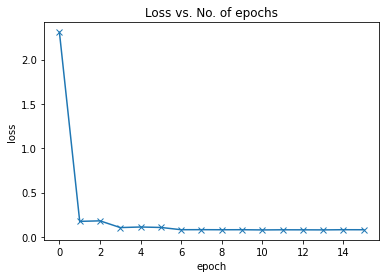

In [130]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

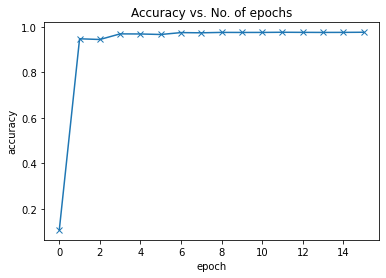

In [131]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Our current model outperforms the logistic regression model (which could only achieve around 86% accuracy) by a considerable margin! It quickly reaches an accuracy of 97% but doesn't improve much beyond this. To improve accuracy further, we need to make the model more powerful by increasing the hidden layer's size or adding more hidden layers with activations. I encourage you to try out both these approaches and see which one works better.

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the `ToTensor` transform.

In [132]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [133]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Let's try it out with a few images.

Label: 7 , Predicted: 7


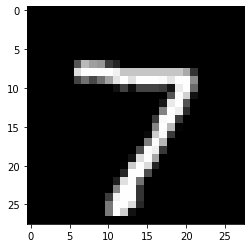

In [134]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


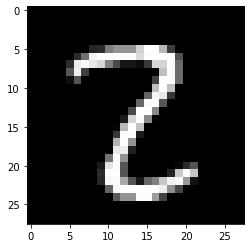

In [135]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


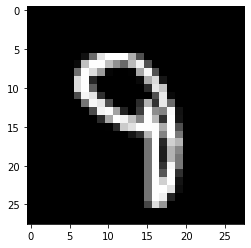

In [136]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [137]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.9761718511581421, 'val_loss': 0.07477708905935287}

We expect this to be similar to the accuracy/loss on the validation set. If not, we might need a better validation set that has similar data and distribution as the test set (which often comes from real world data).

In [138]:
torch.save(model.state_dict(), 'mnist-feedforwardv1.pth')

## Exercises

Try out the following exercises to apply the concepts and techniques you have learned so far:

* Coding exercises on end-to-end model training: https://jovian.ai/aakashns/03-cifar10-feedforward
* Starter notebook for deep learning models:  https://jovian.ai/aakashns/fashion-feedforward-minimal

Training great machine learning models reliably takes practice and experience. Try experimenting with different datasets, models and hyperparameters, it's the best way to acquire this skill.

## Summary and Further Reading

Here is a summary of the topics covered in this tutorial:

* We created a neural network with one hidden layer to improve upon the logistic regression model from the previous tutorial. We also used the ReLU activation function to introduce non-linearity into the model, allowing it to learn more complex relationships between the inputs (pixel densities) and outputs (class probabilities).

* We defined some utilities like `get_default_device`, `to_device` and `DeviceDataLoader` to leverage a GPU if available, by moving the input data and model parameters to the appropriate device.

* We were able to use the exact same training loop: the `fit` function we had define earlier to train out model and evaluate it using the validation dataset.

There's a lot of scope to experiment here, and I encourage you to use the interactive nature of Jupyter to play around with the various parameters. Here are a few ideas:

* Try changing the size of the hidden layer, or add more hidden layers and see if you can achieve a higher accuracy.

* Try changing the batch size and learning rate to see if you can achieve the same accuracy in fewer epochs.

* Compare the training times on a CPU vs. GPU. Do you see a significant difference. How does it vary with the size of the dataset and the size of the model (no. of weights and parameters)?

* Try building a model for a different dataset, such as the [CIFAR10 or CIFAR100 datasets](https://www.cs.toronto.edu/~kriz/cifar.html).

Here are some references for further reading:

* [A visual proof that neural networks can compute any function](http://neuralnetworksanddeeplearning.com/chap4.html), also known as the Universal Approximation Theorem.

* [But what *is* a neural network?](https://www.youtube.com/watch?v=aircAruvnKk) - A visual and intuitive introduction to what neural networks are and what the intermediate layers represent

* [Stanford CS229 Lecture notes on Backpropagation](http://cs229.stanford.edu/notes/cs229-notes-backprop.pdf) - for a more mathematical treatment of how gradients are calculated and weights are updated for neural networks with multiple layers.


You are now ready to move on to the next tutorial: [Image Classification using Convolutional Neural Networks](https://jovian.ai/aakashns/05-cifar10-cnn).